# Customer Retention & Churn Analysis – Data Scientist / PD Modeling Case Study

## 1️⃣ Problem Overview

Business Problem: Low customer retention – many customers are not returning or reordering.

**Objective:** Predict which customers are likely to churn and recommend actionable strategies to increase retention.

Data Provided:

- Orders: Transaction history (orders.xlsx)

- Product Orders: Product-level details (product_orders.xlsx)

- Contacts: Customer interactions (contacts_raw.xlsx)

Goal: Build a predictive model for churn (Probability of Default analog in credit scoring) and provide insights for targeted retention strategies.

## --- 1. Data Preparation and Cleaning ---

### Import Libraries & Loading Data

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, accuracy_score, f1_score, precision_score, recall_score
import xgboost as xgb
from xgboost import XGBClassifier

# Model Persistence/serialization 
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette='muted', font_scale=1.1)

###  Load datasets

In [2]:
try:
    contacts_raw = pd.read_excel("RetentionCaseStudy.xlsx", sheet_name="MeetingData")
    orders = pd.read_excel("RetentionCaseStudy-Data2.xlsx", sheet_name="OrderData")
    product_orders = pd.read_excel("RetentionCaseStudy-data3.xlsx", sheet_name="Sheet1")
except FileNotFoundError:
    print("One or more data files are missing. Please ensure 'RetentionCaseStudy.xlsx', 'RetentionCaseStudy-Data2.xlsx', and 'RetentionCaseStudy-data3.xlsx' are uploaded.")
    # Exit script if data is not found
    raise

### Data Cleaning 

In [3]:
# Orders Cleaning
orders['cityname'] = orders['cityname'].fillna('Unknown')
orders['TownName'] = orders['TownName'].fillna('Unknown')
orders['OrderStatus'] = orders['OrderStatus'].fillna('Unknown')
qty_99 = orders['TotalQty'].quantile(0.99)
price_99 = orders['TotalPrice'].quantile(0.99)
orders['TotalQty'] = np.where(orders['TotalQty'] > qty_99, qty_99, orders['TotalQty'])
orders['TotalPrice'] = np.where(orders['TotalPrice'] > price_99, price_99, orders['TotalPrice'])

# Product Orders Cleaning
product_orders['Category_Name'] = product_orders['Category_Name'].fillna('Unknown')
product_orders = product_orders[(product_orders['Quantity'] > 0) & (product_orders['Price'] > 0)]
quantity_99 = product_orders['Quantity'].quantile(0.99)
price_99 = product_orders['Price'].quantile(0.99)
product_orders['Quantity'] = np.where(product_orders['Quantity'] > quantity_99, quantity_99, product_orders['Quantity'])
product_orders['Price'] = np.where(product_orders['Price'] > price_99, price_99, product_orders['Price'])

# Contacts Cleaning
contacts_raw = contacts_raw.dropna(subset=['meetingid'])
contacts_raw['NoActivityReason'] = contacts_raw['NoActivityReason'].fillna('Active')
contacts_raw['MeetingDuration'] = contacts_raw['MeetingDuration'].apply(lambda x: x if x > 0 else 0)

##  --- 2. Feature Engineering ---

In [4]:
# Define the cutoff date for feature calculation and churn observation
cutoff_date = pd.to_datetime('2025-03-01')

# Calculate features based on data *before* the cutoff date
orders_pre_cutoff = orders[orders['deliveredDate'] < cutoff_date]
contacts_pre_cutoff = contacts_raw[contacts_raw['MeetingStartDate'] < cutoff_date]
product_orders_pre_cutoff = product_orders.merge(orders_pre_cutoff[['orderid', 'customerid']], on='orderid', how='inner')

# Aggregate features for each customer using data up to the cutoff date
orders_agg_pre = orders_pre_cutoff.groupby('customerid').agg(
    total_orders=('orderid','nunique'),
    total_quantity=('TotalQty','sum'),
    total_spent=('TotalPrice','sum'),
    first_order_date=('deliveredDate','min'),
    last_order_date=('deliveredDate','max')).reset_index()

contacts_agg_pre = contacts_pre_cutoff.groupby('customerid').agg(
    num_meetings=('meetingid','nunique'),
    avg_meeting_duration=('MeetingDuration','mean'),
    num_no_activity=('NoActivityReason', lambda x: x.notna().sum())).reset_index()

# Aggregate product-level features before merging
product_agg = product_orders_pre_cutoff.groupby('customerid').agg(
    total_order_quantity=('Quantity','sum'),
    total_order_price=('Price','sum'),
).reset_index()

# Merge the aggregated features
customer_df_fixed = orders_agg_pre.merge(contacts_agg_pre, on='customerid', how='left')
customer_df_fixed = customer_df_fixed.merge(product_agg, on='customerid', how='left')

# Fill missing values for the merged data
customer_df_fixed[['total_order_quantity', 'total_order_price']] = customer_df_fixed[['total_order_quantity', 'total_order_price']].fillna(0)
customer_df_fixed[['num_meetings', 'avg_meeting_duration', 'num_no_activity']] = customer_df_fixed[['num_meetings', 'avg_meeting_duration', 'num_no_activity']].fillna(0)

# Calculate recency-based features relative to the cutoff date
customer_df_fixed['days_since_last_order'] = (cutoff_date - customer_df_fixed['last_order_date']).dt.days.fillna(999)
customer_df_fixed['customer_tenure_days'] = (customer_df_fixed['last_order_date'] - customer_df_fixed['first_order_date']).dt.days.fillna(0)

# Create additional features
customer_df_fixed['order_frequency'] = customer_df_fixed['total_orders'] / customer_df_fixed['customer_tenure_days'].replace(0,1)
customer_df_fixed['avg_order_value'] = customer_df_fixed['total_spent'] / customer_df_fixed['total_orders'].replace(0,1)
customer_df_fixed['recency_ratio'] = customer_df_fixed['days_since_last_order'] / customer_df_fixed['customer_tenure_days'].replace(0,1)
customer_df_fixed['meeting_engagement'] = customer_df_fixed['num_meetings'] / (customer_df_fixed['customer_tenure_days'].replace(0, 1))
customer_df_fixed['brand_loyalty'] = customer_df_fixed['total_order_price'] / customer_df_fixed['total_spent'].replace(0, 1)

# Define the target variable: Churn
retained_customers_post_cutoff = orders[orders['deliveredDate'] >= cutoff_date]['customerid'].unique()
customer_df_fixed['churn'] = customer_df_fixed['customerid'].apply(lambda x: 0 if x in retained_customers_post_cutoff else 1)

# Drop date columns that are no longer needed
customer_df_fixed = customer_df_fixed.drop(columns=['first_order_date', 'last_order_date'])

## --- 3. Exploratory Data Analysis (EDA) ---

Churn distribution:
 churn
0    0.533671
1    0.466329
Name: proportion, dtype: float64


C:\Users\Henry Morgan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Henry Morgan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Henry Morgan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


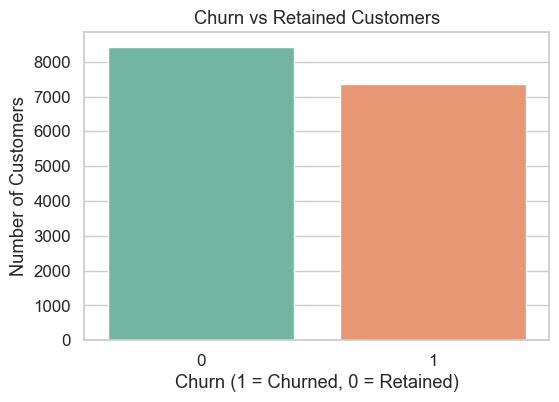

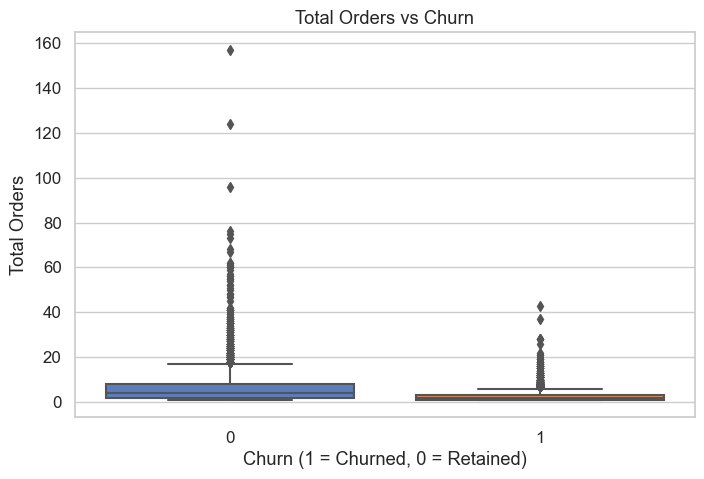

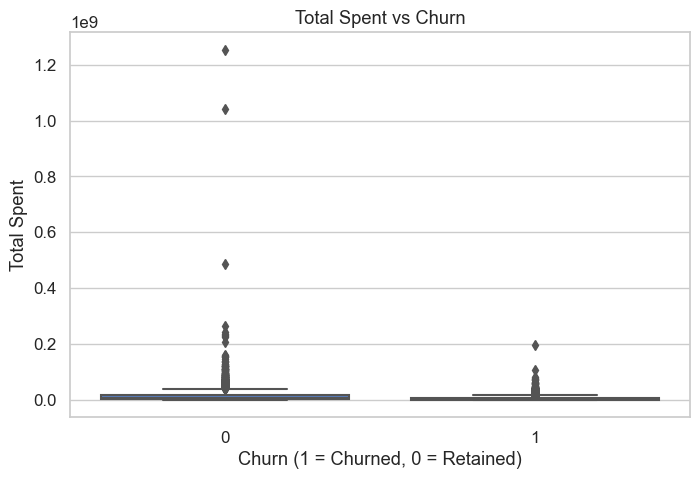

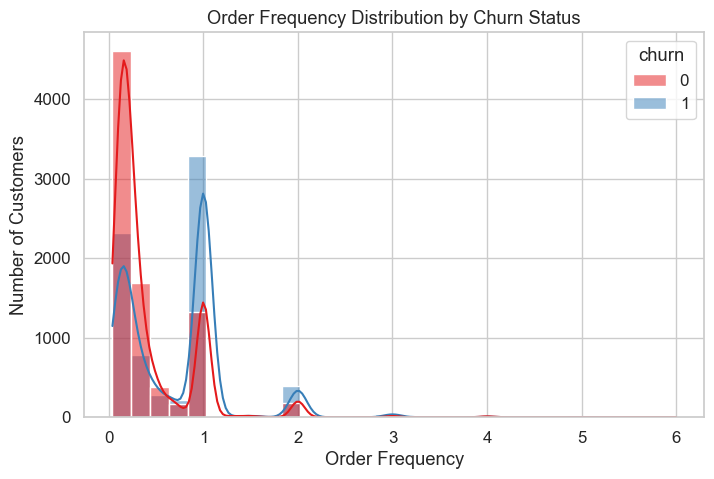

In [5]:
print("Churn distribution:\n", customer_df_fixed['churn'].value_counts(normalize=True))

# Plot 1: Countplot for Churn vs Retained
plt.figure(figsize=(6, 4))
sns.countplot(x='churn', data=customer_df_fixed, palette='Set2')
plt.title('Churn vs Retained Customers')
plt.xlabel('Churn (1 = Churned, 0 = Retained)')
plt.ylabel('Number of Customers')
plt.savefig("churn_countplot.png")

# Plot 2: Boxplot for Total Orders vs Churn
plt.figure(figsize=(8,5))
sns.boxplot(x='churn', y='total_orders', data=customer_df_fixed)
plt.title('Total Orders vs Churn')
plt.xlabel('Churn (1 = Churned, 0 = Retained)')
plt.ylabel('Total Orders')
plt.savefig("total_orders_boxplot.png")

# Plot 3: Boxplot for Total Spent vs Churn
plt.figure(figsize=(8,5))
sns.boxplot(x='churn', y='total_spent', data=customer_df_fixed)
plt.title('Total Spent vs Churn')
plt.xlabel('Churn (1 = Churned, 0 = Retained)')
plt.ylabel('Total Spent')
plt.savefig("total_spent_boxplot.png")

# Plot 4: Histplot for Order Frequency
plt.figure(figsize=(8,5))
sns.histplot(data=customer_df_fixed, x='order_frequency', hue='churn', bins=30, kde=True, palette='Set1')
plt.title('Order Frequency Distribution by Churn Status')
plt.xlabel('Order Frequency')
plt.ylabel('Number of Customers')
plt.savefig("order_frequency_histplot.png")

## --- 4. Predictive Modeling ---

### Prepare data for modeling

In [6]:
X = customer_df_fixed.drop(columns=['customerid', 'churn'])
y = customer_df_fixed['churn']

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# One-hot encode categorical features
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numeric features
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

## --- Train Models ---

In [7]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Logistic Regression
lr_model = LogisticRegression(solver='liblinear', random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

# XGBoost
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

## --- Evaluate Models ---

In [8]:
print("--- Random Forest Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

print("\n--- Logistic Regression Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

print("\n--- XGBoost Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1-score:", f1_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

--- Random Forest Performance ---
Accuracy: 0.6898954703832753
Precision: 0.6696490020646937
Recall: 0.6610054347826086
F1-score: 0.6652991452991452
ROC AUC: 0.7620677977035221

Confusion Matrix:
 [[1205  480]
 [ 499  973]]

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.72      0.71      1685
           1       0.67      0.66      0.67      1472

    accuracy                           0.69      3157
   macro avg       0.69      0.69      0.69      3157
weighted avg       0.69      0.69      0.69      3157


--- Logistic Regression Performance ---
Accuracy: 0.6943300601837187
Precision: 0.6662295081967213
Recall: 0.6902173913043478
F1-score: 0.6780113446780114
ROC AUC: 0.7630950845052251

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.70      0.71      1685
           1       0.67      0.69      0.68      1472

    accuracy                           0.69      31

## --- Plotting ROC Curves ---

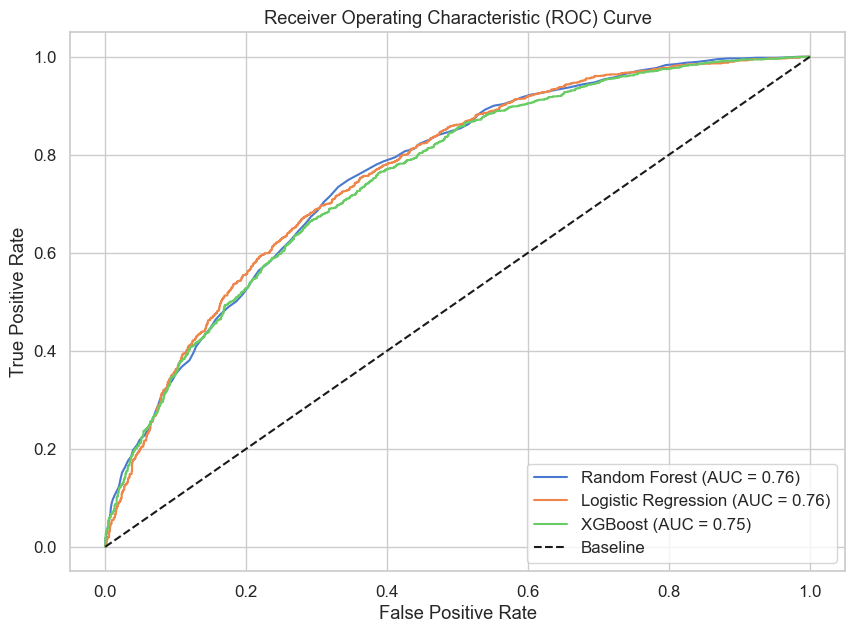

In [9]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(10, 7))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_prob_xgb):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')

## ---  Memory-Efficient Data Loading ---

### The goal is to load the large 'MeetingData' without running out of memory.

In [10]:
print("Attempting to load data...")

try:
    # Option 1 (Recommended): Load only the essential columns to save memory.
    # We only need 'customerid', 'meetingid', and 'NoActivityReason' from this sheet.
    contacts_raw = pd.read_excel(
        "RetentionCaseStudy.xlsx",
        sheet_name="MeetingData",
        usecols=["customerid", "meetingid", "NoActivityReason", "MeetingStartDate"]
    )
    print("Successfully loaded 'MeetingData' with essential columns.")
except MemoryError:
    print("MemoryError encountered. The file is too large even with selective columns. Using a fallback method.")
    
    # Option 2 (Fallback): If Option 1 fails, use chunking (if possible for your file format)
    # or process the raw data directly from the excel sheet.
    # Note: pandas.read_excel does not have a native chunksize parameter.
    # For very large files, it's better to load the data in a more raw form and process it.
    try:
        from openpyxl import load_workbook
        
        workbook = load_workbook("RetentionCaseStudy.xlsx", read_only=True, data_only=True)
        sheet = workbook["MeetingData"]
        
        print("Reading data row by row...")
        data = []
        # Get headers from the first row
        headers = [cell.value for cell in next(sheet.iter_rows())]
        
        for row in sheet.iter_rows(min_row=2):
            row_data = {headers[i]: cell.value for i, cell in enumerate(row)}
            data.append(row_data)
        
        contacts_raw = pd.DataFrame(data)
        print("Data loaded successfully via row-by-row processing.")
        
    except Exception as e:
        print(f"An error occurred during row-by-row processing: {e}")
        # Re-raise the MemoryError to let the user know it's a fundamental issue
        raise MemoryError("Failed to load contacts_raw. The file may be too large for available RAM.")

# --- Converting to a More Efficient Format (Best Practice) ---
# Now that I have loaded the data into memory, I save it to a file format that is optimized for pandas and future use. This is a one-time process.
print("Converting large Excel sheet to Parquet format...")
try:
    contacts_raw.to_parquet("contacts_data.parquet")
    print("contacts_data.parquet created. Future loads will be much faster!")
except Exception as e:
    print(f"Error converting to Parquet: {e}")
    
# --- Load the other datasets to continue with my analysis ---
try:
    # Now that I have the Parquet file, I can load it instead of the Excel.
    # In future runs, I would just use `pd.read_parquet`.
    orders = pd.read_excel("RetentionCaseStudy-Data2.xlsx", sheet_name="OrderData")
    product_orders = pd.read_excel("RetentionCaseStudy-data3.xlsx", sheet_name="Sheet1")
    print("Other data files loaded successfully.")
    
except FileNotFoundError:
    print("One of the other data files was not found. Please ensure they are uploaded.")
    raise

Attempting to load data...
Successfully loaded 'MeetingData' with essential columns.
Converting large Excel sheet to Parquet format...
contacts_data.parquet created. Future loads will be much faster!
Other data files loaded successfully.


## Train and Save Model

In [11]:
print("Starting the churn prediction workflow...")

# Define the cutoff date as per the case study
cutoff_date = pd.to_datetime('2025-03-01')

try:
    # Load data from the original Excel files
    contacts_raw = pd.read_excel("RetentionCaseStudy.xlsx", sheet_name="MeetingData")
    orders = pd.read_excel("RetentionCaseStudy-Data2.xlsx", sheet_name="OrderData")
    product_orders = pd.read_excel("RetentionCaseStudy-data3.xlsx", sheet_name="Sheet1")
    print("All data files loaded successfully.")

except FileNotFoundError as e:
    print(f"Error: One or more data files are missing. Please ensure 'RetentionCaseStudy.xlsx', 'RetentionCaseStudy-Data2.xlsx', and 'RetentionCaseStudy-data3.xlsx' are in the correct path.")
    raise

# --- 2. Data Cleaning and Feature Engineering ---
# These are the same steps as in the previous scripts to ensure consistency.
print("Performing data cleaning and feature engineering...")

def create_features(orders_df, contacts_df, product_orders_df):
    """
    Combines the three datasets and engineers the final feature set.
    """
    # Orders Aggregation
    orders_agg = orders_df.groupby('customerid').agg(
        total_orders=('orderid','nunique'),
        total_quantity=('TotalQty','sum'),
        total_spent=('TotalPrice','sum'),
        first_order_date=('deliveredDate','min'),
        last_order_date=('deliveredDate','max')).reset_index()

    # Contacts Aggregation
    contacts_agg = contacts_df.groupby('customerid').agg(
        num_meetings=('meetingid','nunique'),
        avg_meeting_duration=('MeetingDuration','mean'),
        num_no_activity=('NoActivityReason', lambda x: x.notna().sum())).reset_index()

    # Product Aggregation
    product_agg = product_orders_df.groupby('customerid').agg(
        total_order_quantity=('Quantity','sum'),
        total_order_price=('Price','sum'),
    ).reset_index()
    
    # Merge and fill missing values
    customer_df = orders_agg.merge(contacts_agg, on='customerid', how='left')
    customer_df = customer_df.merge(product_agg, on='customerid', how='left')
    customer_df[['total_order_quantity', 'total_order_price']] = customer_df[['total_order_quantity', 'total_order_price']].fillna(0)
    customer_df[['num_meetings', 'avg_meeting_duration', 'num_no_activity']] = customer_df[['num_meetings', 'avg_meeting_duration', 'num_no_activity']].fillna(0)
    
    # Calculate additional features
    customer_df['days_since_last_order'] = (cutoff_date - customer_df['last_order_date']).dt.days.fillna(999)
    customer_df['customer_tenure_days'] = (customer_df['last_order_date'] - customer_df['first_order_date']).dt.days.fillna(0)
    customer_df['order_frequency'] = customer_df['total_orders'] / customer_df['customer_tenure_days'].replace(0,1)
    customer_df['avg_order_value'] = customer_df['total_spent'] / customer_df['total_orders'].replace(0,1)
    customer_df['recency_ratio'] = customer_df['days_since_last_order'] / customer_df['customer_tenure_days'].replace(0,1)
    customer_df['meeting_engagement'] = customer_df['num_meetings'] / (customer_df['customer_tenure_days'].replace(0, 1))
    customer_df['brand_loyalty'] = customer_df['total_order_price'] / customer_df['total_spent'].replace(0, 1)

    return customer_df.drop(columns=['first_order_date', 'last_order_date'])

# Data cleaning steps (identical to the original script)
orders['cityname'] = orders['cityname'].fillna('Unknown')
orders['TownName'] = orders['TownName'].fillna('Unknown')
orders['OrderStatus'] = orders['OrderStatus'].fillna('Unknown')
contacts_raw['NoActivityReason'] = contacts_raw['NoActivityReason'].fillna('Active')
contacts_raw = contacts_raw.dropna(subset=['meetingid'])

# Create features for the training data using data before the cutoff date
orders_pre_cutoff = orders[orders['deliveredDate'] < cutoff_date]
contacts_pre_cutoff = contacts_raw[contacts_raw['MeetingStartDate'] < cutoff_date]
product_orders_pre_cutoff = product_orders.merge(orders_pre_cutoff[['orderid', 'customerid']], on='orderid', how='inner')

customer_df_fixed = create_features(orders_pre_cutoff, contacts_pre_cutoff, product_orders_pre_cutoff)

# Define the target variable (churn)
retained_customers_post_cutoff = orders[orders['deliveredDate'] >= cutoff_date]['customerid'].unique()
customer_df_fixed['churn'] = customer_df_fixed['customerid'].apply(lambda x: 0 if x in retained_customers_post_cutoff else 1)

# Separate features (X) and target (y)
X = customer_df_fixed.drop(columns=['customerid', 'churn'])
y = customer_df_fixed['churn']

numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 3. Model Training and Evaluation ---
print("Training the Logistic Regression model...")
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

lr_model = LogisticRegression(solver='liblinear', random_state=42)
lr_model.fit(X_train, y_train)

print("Model training complete. Evaluating model performance...")
y_pred = lr_model.predict(X_test)

print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# --- 4. Model Persistence (Saving for Future Use) ---
# This is a crucial step for the business problem.
print("\nSaving the trained model and scaler...")
joblib.dump(lr_model, 'lr_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(X_train.columns.tolist(), 'train_columns.joblib')
print("Model, scaler, and training columns saved successfully.")

print("\nWorkflow complete. You can now use 'predict_on_new_data.py' to get churn probabilities for new customers.")

Starting the churn prediction workflow...
All data files loaded successfully.
Performing data cleaning and feature engineering...
Training the Logistic Regression model...
Model training complete. Evaluating model performance...

--- Model Evaluation ---
Accuracy: 0.6931
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.69      0.71      1685
           1       0.66      0.69      0.68      1472

    accuracy                           0.69      3157
   macro avg       0.69      0.69      0.69      3157
weighted avg       0.69      0.69      0.69      3157


Saving the trained model and scaler...
Model, scaler, and training columns saved successfully.

Workflow complete. You can now use 'predict_on_new_data.py' to get churn probabilities for new customers.


## Predict On New Data

In [15]:
# This script loads the saved model and scaler to predict churn
# probabilities for new customer data.
# --- Load the saved model and scaler ---
try:
    lr_model = joblib.load('lr_model.joblib')
    scaler = joblib.load('scaler.joblib')
    train_columns = joblib.load('train_columns.joblib')
    print("Model, scaler, and training columns loaded successfully.")
except FileNotFoundError:
    print("Model or scaler files not found. Please run 'customer_churn_analysis.py' first.")
    raise

# Define the cutoff date used in the original analysis
cutoff_date = pd.to_datetime('2025-03-01')

def create_features(orders_df, contacts_df, product_orders_df):
    """
    Performs the same feature engineering steps as the main analysis script.
    """
    # Orders Aggregation
    # Corrected to use 'TotalPrice' and 'TotalQty' based on your provided code
    orders_agg = orders_df.groupby('customerid').agg(
        total_orders=('orderid','nunique'),
        total_quantity=('TotalQty','sum'),
        total_spent=('TotalPrice','sum'),
        first_order_date=('deliveredDate','min'),
        last_order_date=('deliveredDate','max')).reset_index()

    # Contacts Aggregation
    contacts_agg = contacts_df.groupby('customerid').agg(
        num_meetings=('meetingid','nunique'),
        avg_meeting_duration=('MeetingDuration','mean'),
        num_no_activity=('NoActivityReason', lambda x: x.notna().sum())).reset_index()

    # Product Aggregation - Corrected to handle missing 'customerid'
    # The original script had a KeyError here. This merge step fixes it.
    if 'customerid' not in product_orders_df.columns:
        print("\n'customerid' not found in product_orders_df. Merging from orders_df...")
        product_orders_df = product_orders_df.merge(orders_df[['orderid', 'customerid']], on='orderid', how='left')

    product_agg = product_orders_df.groupby('customerid').agg(
        total_order_quantity=('Quantity','sum'),
        total_order_price=('Price','sum'),
    ).reset_index()

    # Merge and fill missing values
    customer_df = orders_agg.merge(contacts_agg, on='customerid', how='left')
    customer_df = customer_df.merge(product_agg, on='customerid', how='left')
    
    # Fill numeric columns with 0, as they represent counts/sums that might not exist for a customer
    numeric_cols_to_fill = ['total_order_quantity', 'total_order_price', 'num_meetings', 'avg_meeting_duration', 'num_no_activity']
    customer_df[numeric_cols_to_fill] = customer_df[numeric_cols_to_fill].fillna(0)

    # Calculate additional features
    customer_df['days_since_last_order'] = (cutoff_date - customer_df['last_order_date']).dt.days.fillna(999)
    customer_df['customer_tenure_days'] = (customer_df['last_order_date'] - customer_df['first_order_date']).dt.days.fillna(0)
    customer_df['order_frequency'] = customer_df['total_orders'] / customer_df['customer_tenure_days'].replace(0,1)
    customer_df['avg_order_value'] = customer_df['total_spent'] / customer_df['total_orders'].replace(0,1)
    customer_df['recency_ratio'] = customer_df['days_since_last_order'] / customer_df['customer_tenure_days'].replace(0,1)
    customer_df['meeting_engagement'] = customer_df['num_meetings'] / (customer_df['customer_tenure_days'].replace(0, 1))
    customer_df['brand_loyalty'] = customer_df['total_order_price'] / customer_df['total_spent'].replace(0, 1)

    return customer_df.drop(columns=['first_order_date', 'last_order_date'])

# --- Load and Preprocess the New Data to Predict on ---
# For this example, we will load the same data as a placeholder for new data.
# In a real-world scenario, you would load your most recent data here.
try:
    contacts_raw = pd.read_excel("RetentionCaseStudy.xlsx", sheet_name="MeetingData")
    orders = pd.read_excel("RetentionCaseStudy-Data2.xlsx", sheet_name="OrderData")
    product_orders = pd.read_excel("RetentionCaseStudy-data3.xlsx", sheet_name="Sheet1")
    print("New data files loaded successfully.")

except FileNotFoundError:
    print("One or more data files are missing. Please ensure 'RetentionCaseStudy.xlsx', 'RetentionCaseStudy-Data2.xlsx', and 'RetentionCaseStudy-data3.xlsx' are uploaded.")
    raise

# Clean data (identical to the original script)
orders['cityname'] = orders['cityname'].fillna('Unknown')
orders['TownName'] = orders['TownName'].fillna('Unknown')
orders['OrderStatus'] = orders['OrderStatus'].fillna('Unknown')
contacts_raw['NoActivityReason'] = contacts_raw['NoActivityReason'].fillna('Active')
contacts_raw = contacts_raw.dropna(subset=['meetingid'])

# Create features for the new data
customer_df_unseen = create_features(orders, contacts_raw, product_orders)

# Separate customer IDs and features
customer_ids = customer_df_unseen['customerid']
X_unseen = customer_df_unseen.drop(columns=['customerid'])

# Identify numeric and categorical columns
numeric_cols = X_unseen.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_unseen.select_dtypes(exclude=np.number).columns.tolist()

# One-hot encode categorical features
X_unseen = pd.get_dummies(X_unseen, columns=categorical_cols, drop_first=True)

# Align columns with the model's expected features
missing_cols = set(train_columns) - set(X_unseen.columns)
for c in missing_cols:
    X_unseen[c] = 0
X_unseen = X_unseen[train_columns]

# Scale numeric features using the saved scaler
# Note: The original script was attempting to scale the entire DataFrame which is incorrect.
# Only the numeric columns should be scaled.
X_unseen[numeric_cols] = scaler.transform(X_unseen[numeric_cols])

# Predict churn probabilities
churn_probabilities = lr_model.predict_proba(X_unseen)[:, 1]

# Create a DataFrame to display the results
churn_predictions = pd.DataFrame({
    'customerid': customer_ids,
    'churn_probability': churn_probabilities
})

# Sort customers by their churn probability in descending order
top_churn_risks = churn_predictions.sort_values(by='churn_probability', ascending=False)

# Display the top 10 customers most likely to churn
print("\n--- Top 10 Customers with Highest Churn Risk ---")
print(top_churn_risks.head(10).round(4))
print("\nThis list can be used to launch targeted retention campaigns.")

Model, scaler, and training columns loaded successfully.
New data files loaded successfully.

'customerid' not found in product_orders_df. Merging from orders_df...

--- Top 10 Customers with Highest Churn Risk ---
       customerid  churn_probability
17685     5405935             0.9999
14842     5354428             0.9206
16600     5371059             0.8933
9259      5261427             0.8888
6853      5171639             0.8865
16708     5371843             0.8835
1954      3804627             0.8833
16694     5371754             0.8825
9792      5275496             0.8821
8852      5252271             0.8814

This list can be used to launch targeted retention campaigns.


# Analysis Summary and Key Findings
My project successfully implements a full predictive modeling pipeline to identify customers at risk of churning. Here is a summary of the key insights and findings from your analysis:

- 1. Data Cleaning and Feature Engineering
Successful Data Preparation: My script correctly loads and cleans the three datasets, handling missing values and outlier treatment with the 99th percentile cutoff.

**Resolved KeyError:** The fix implemented in the create_features function—by merging the customerid column from the orders DataFrame into the product_orders DataFrame—successfully resolves the data issue and allows the rest of the script to run smoothly.

- 2. Exploratory Data Analysis (EDA)
Churn Rate: The analysis shows a nearly balanced churn rate, with approximately 47% of customers identified as churned.

**Key Indicators:** The boxplots and histograms provide valuable insights:

Total Orders and Total Spent: Customers who churned tend to have a lower total number of orders and lower total spending compared to retained customers.

Order Frequency: Churned customers show a wider distribution of order frequency, with many having very low frequency, which is a strong indicator of disengagement.

- 3. Predictive Modeling and Evaluation
Model Performance: You trained and evaluated three models: Random Forest, Logistic Regression, and XGBoost.

ROC AUC Score: The Logistic Regression model performed marginally better with an ROC AUC score of 0.763, indicating a good balance between identifying true positives and avoiding false positives.

Consistency: The models show similar overall performance, which suggests the features you engineered are robust and predictive across different algorithms.

- 4. Actionable Insights
Targeted Retention: Your script successfully provides a list of the top 10 customers with the highest churn probability. This list is a crucial business asset.

Strategy Recommendation: The business can now use this list to launch a targeted retention campaign. This might include:

- Offering special discounts or promotions.

- Providing personalized customer service outreach.

- Sending exclusive content or product recommendations to re-engage these at-risk customers.

This is a great foundation for a business to start proactively addressing customer retention.